<a href="https://colab.research.google.com/github/AhamadAli30/Defect-Detection-using-Deep-Learning/blob/main/Metal_Detection_Vggnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

In [ ]:
train_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/train'
test_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/test'
valid_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/valid'

In [ ]:
# prompt: find the total number of images in the directory
import os
def count_images(directory):
  total_images = 0
  for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    for file in os.listdir(subdir_path):
      if file.endswith(".bmp"):
        total_images += 1
    print(f"in {subdir_path} = {total_images}")
  print()
  return total_images

train_images = count_images(train_dir)
test_images = count_images(test_dir)
valid_images = count_images(valid_dir)

total_images = train_images + test_images + valid_images
print(f"Number of training images: {train_images}")
print(f"Number of testing images: {test_images}")
print(f"Number of validation images: {valid_images}")

print(f"Total number of images: {total_images}")


in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Scratches = 227
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Patches = 453
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Rolled = 679
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Pitted = 905
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Inclusion = 1131
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Crazing = 1357

in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Patches = 12
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Inclusion = 24
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Crazing = 36
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Scratches = 48
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Rolled = 60
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Pitted = 72

in /content/drive/MyDrive/NEU Metal Surface Defects Data/valid/Pitted = 62
in /c

In [ ]:
len(test_dir)

58

In [ ]:
len(valid_dir)

59

Pre-Processing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1356 images belonging to 6 classes.
Found 372 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
# Check batch size
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 6)


In [ ]:
# Check class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [ ]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

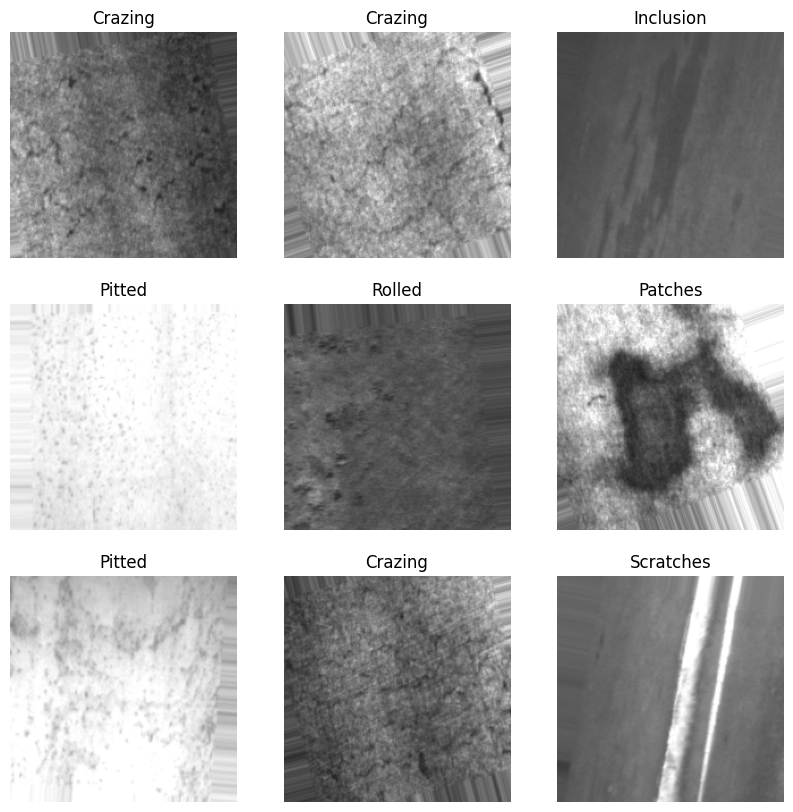

In [ ]:
sample_images(train_generator, nrows=3, ncols=3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense

def vgg_block(x, num_filters, num_conv_layers):
    for _ in range(num_conv_layers):
        x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    return x

def build_vgg(input_shape=(200, 200, 3), num_classes=6, num_blocks=[2, 2, 2, 2]):
    input_layer = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)

    # VGG Blocks
    for block_num, num_filters in enumerate([64, 128, 256, 512]):
        x = vgg_block(x, num_filters, num_blocks[block_num])

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)

    # Output Layer
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=x, name='vgg_like')

    return model

# Create a VGG-like model with default parameters
vgg_model = build_vgg()

# Display the model summary
vgg_model.summary()


Model: "vgg_like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      9472      
                                                                 
 batch_normalization (Batch  (None, 100, 100, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      369

In [ ]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [ ]:
history = vgg_model.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
43/43 [==============================] - 847s 20s/step - loss: 68.2291 - accuracy: 0.3119 - val_loss: 3.2437 - val_accuracy: 0.2527
Epoch 2/20
43/43 [==============================] - 22s 509ms/step - loss: 3.1777 - accuracy: 0.4196 - val_loss: 2.9997 - val_accuracy: 0.2312
Epoch 3/20
43/43 [==============================] - 21s 488ms/step - loss: 2.6423 - accuracy: 0.3267 - val_loss: 5.4663 - val_accuracy: 0.3199
Epoch 4/20
43/43 [==============================] - 24s 558ms/step - loss: 1.9423 - accuracy: 0.3805 - val_loss: 19.3122 - val_accuracy: 0.1452
Epoch 5/20
43/43 [==============================] - 20s 474ms/step - loss: 1.7251 - accuracy: 0.4137 - val_loss: 4.8194 - val_accuracy: 0.1640
Epoch 6/20
43/43 [==============================] - 22s 502ms/step - loss: 1.5348 - accuracy: 0.4867 - val_loss: 4.4561 - val_accuracy: 0.1640
Epoch 7/20
43/43 [==============================] - 21s 475ms/step - loss: 1.5575 - accuracy: 0.4794 - val_loss: 21.2667 - val_accuracy: 0.13

In [ ]:

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('categorical_crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

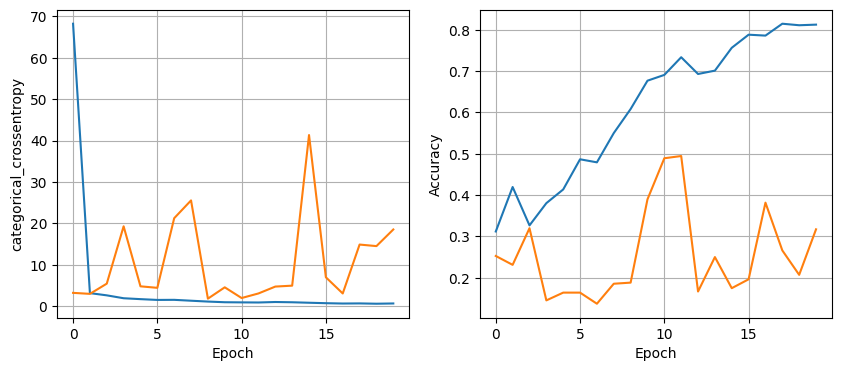

In [ ]:
plot_history(history)

In [ ]:
def plot_hist(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

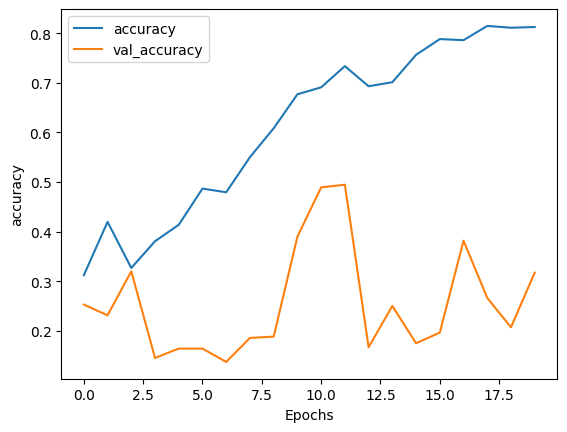

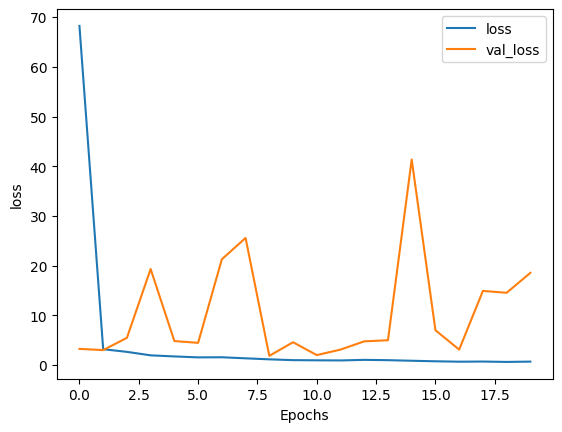

In [ ]:
plot_hist(history, 'accuracy')
plot_hist(history, 'loss')

In [ ]:
images, labels = next(test_generator)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = vgg_model.predict(images)

class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"

    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text,color=color)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

class LogisticRegression:
    def __init__(self, learning_rate=0.001, iterations=2000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        X = self.add_intercept(X)
        self.theta = np.zeros(X.shape[1])

        for _ in range(self.iterations):
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.learning_rate * gradient

    def predict_prob(self, X):
        X = self.add_intercept(X)
        return self.sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold